* Virtual Idol과 Real Idol 분석 - NLP 파트
* 워드클라우드, TF-IDF 코사인 유사도, unigram / n-gram 네트워크, CONCOR 분석

In [54]:
import pandas as pd
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import ast
from itertools import chain

from konlpy.tag import Okt
from kiwipiepy import Kiwi

from collections import Counter
from wordcloud import WordCloud
import networkx as nx
from PIL import Image

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity


# 0. 함수정의

In [2]:
def parse_list_str(x):
    # NaN/None 방어
    if x is None:
        return []
    # 이미 list면 그대로
    if isinstance(x, list):
        return x
    # 문자열이면 리스트로 파싱 시도
    if isinstance(x, str):
        x = x.strip()
        if x == "" or x == "[]":
            return []
        try:
            v = ast.literal_eval(x)   # "['안녕']" -> ['안녕']
            return v if isinstance(v, list) else []
        except (ValueError, SyntaxError):
            return []  # 파싱 실패하면 빈 리스트로
    return []

In [3]:
def keep_topk_per_row(M, k, symmetric="max"):
    """
    M: (n,n) similarity matrix (numpy array)
    k: keep top-k neighbors per node (per row), excluding diagonal
    symmetric:
      - "max": keep edge if either direction keeps it (union)  ✅ 추천
      - "min": keep edge only if both directions keep it (mutual top-k, intersection)
    """
    M = M.copy()
    np.fill_diagonal(M, 0.0)

    n = M.shape[0]
    out = np.zeros_like(M)

    for i in range(n):
        row = M[i]
        # k가 n-1보다 크면 전부 유지
        kk = min(k, n - 1)
        if kk <= 0:
            continue

        # 상위 kk 인덱스 (정렬 전체 하지 않고 빠르게)
        idx = np.argpartition(row, -kk)[-kk:]
        out[i, idx] = row[idx]

    if symmetric == "max":
        out = np.maximum(out, out.T)
    elif symmetric == "min":
        out = np.minimum(out, out.T)
    else:
        raise ValueError("symmetric must be 'max' or 'min'")

    return out

In [4]:
# 3) UCINET DL(fullmatrix)로 저장
def save_ucinet_dl_fullmatrix(df, path):
    labels = ", ".join(df.index.tolist())
    n = df.shape[0]
    with open(path, "w", encoding="CP949") as f:
        f.write(f"DL n={n}\n")
        f.write("format=fullmatrix\n")
        f.write("labels:\n")
        f.write(labels + "\n")
        f.write("data:\n")
        for row in df.values:
            f.write(" ".join(f"{v:.6f}" for v in row) + "\n")

# 1. 데이터 불러오기

In [6]:
df = pd.read_csv(
    "../cocacoca0810/data/01_raw/youtube_comments_origin.csv",
)

df.head()

,video_id,comment_id,comment_text,like_count,published_at
0,k5O1F_IS0mU,Ugykjh0_hVuTgqN8doR4AaABAg,그냥 얘들아 내가 진짜 ㅠ 애정한다 ㅠ 나 이렇게 애정해본 아이돌이 너네가 처음이고...,0,2026-01-31T15:59:29Z
1,k5O1F_IS0mU,Ugx1c4OKEnkVwGWBlFB4AaABAg,눈물이 난다,2,2026-01-23T04:29:25Z
2,k5O1F_IS0mU,UgwaAbmKOm2vwOgFEFp4AaABAg,이 노래도 겁나 좋네,2,2026-01-20T01:52:56Z
3,k5O1F_IS0mU,UgzquReVBuSocVLtI7t4AaABAg,"패러블, 이제 뉴세돌로 리와인드 다시 찍어 올려라!!! 이세돌 더 이쁜 버전으로 보...",3,2026-01-19T11:10:22Z
4,k5O1F_IS0mU,UgwM02x2Puib48rQTuF4AaABAg,언제 들어도 행복하고 좋은 노래..,2,2026-01-16T02:53:32Z


In [7]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 254637 entries, 0 to 254636
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   video_id      254637 non-null  str  
 1   comment_id    254637 non-null  str  
 2   comment_text  254516 non-null  str  
 3   like_count    254637 non-null  int64
 4   published_at  254637 non-null  str  
dtypes: int64(1), str(4)
memory usage: 9.7 MB


# 2. Word Cloud

In [ ]:
## tokenized data

df = pd.read_csv(
    "../cocacoca0810/data/01_raw/subsets/Full_youtube_comments_N_A.csv",
)

df.columns.values[0] = 'video_id'

df.head()

,video_id,keywords
0,k5O1F_IS0mU,"['진짜', '애정', '애정', '아이돌', '처음', '콘서트', '아이돌', ..."
1,k5O1F_IS0mU,['눈물']
2,k5O1F_IS0mU,"['노래', '좋네']"
3,k5O1F_IS0mU,"['패러블', '다시', '이쁜', '버전']"
4,k5O1F_IS0mU,"['언제', '행복하고', '좋은', '노래']"


In [265]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 254516 entries, 0 to 254515
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   video_id  254516 non-null  str  
 1   keywords  75005 non-null   str  
dtypes: str(2)
memory usage: 3.9 MB


In [266]:
df = df.dropna()
df.info()

<class 'pandas.DataFrame'>
Index: 75005 entries, 0 to 254511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   video_id  75005 non-null  str  
 1   keywords  75005 non-null  str  
dtypes: str(2)
memory usage: 1.7 MB


In [267]:
df['video_id'].value_counts()

# 라이즈 영상에 단어 리스트가 133 밖에 없는걸 확인할 수 있다.

video_id
6ZUIwj3FgUY    21800
rDFUl2mHIW4    15988
EYG4ROejmyI    10613
8L001YT4k6k     8522
B1ShLiq3EVc     5028
T_gJpnjJsnk     3515
fff8P0kYexQ     3073
TVqEwvbZP30     2679
iUw3LPM7OBU     2178
k5O1F_IS0mU     1024
bltjk6NfDQM      444
3_b5oKGndn0      141
Name: count, dtype: int64

In [268]:
video_to_group = {
    "8L001YT4k6k": "PLAVE",
    "EYG4ROejmyI": "PLAVE",
    "T_gJpnjJsnk": "PLAVE",

    "bltjk6NfDQM": "IVE",
    "B1ShLiq3EVc": "IVE",
    "6ZUIwj3FgUY": "IVE",
    
    "iUw3LPM7OBU": "RIIZE",
    "3_b5oKGndn0": "RIIZE",
    "TVqEwvbZP30": "RIIZE",
    
    "k5O1F_IS0mU": "ISEGYE IDOL",
    "rDFUl2mHIW4": "ISEGYE IDOL",
    "fff8P0kYexQ": "ISEGYE IDOL"
}

In [269]:
df["group"] = df["video_id"].map(video_to_group)

In [270]:
df.head()

,video_id,keywords,group
0,k5O1F_IS0mU,"['진짜', '애정', '애정', '아이돌', '처음', '콘서트', '아이돌', ...",ISEGYE IDOL
1,k5O1F_IS0mU,['눈물'],ISEGYE IDOL
2,k5O1F_IS0mU,"['노래', '좋네']",ISEGYE IDOL
3,k5O1F_IS0mU,"['패러블', '다시', '이쁜', '버전']",ISEGYE IDOL
4,k5O1F_IS0mU,"['언제', '행복하고', '좋은', '노래']",ISEGYE IDOL


In [271]:
df.info()

<class 'pandas.DataFrame'>
Index: 75005 entries, 0 to 254511
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   video_id  75005 non-null  str  
 1   keywords  75005 non-null  str  
 2   group     75005 non-null  str  
dtypes: str(3)
memory usage: 2.3 MB


In [272]:
# 각 그룹별 단어 리스트 개수
df['group'].value_counts()

group
IVE            27272
PLAVE          22650
ISEGYE IDOL    20085
RIIZE           4998
Name: count, dtype: int64

In [273]:
# V와 R 나누기 위한 컬럼 추가
df['is_real'] = df['group'].str.contains(r'RIIZE|IVE', case=False)
df.head()

,video_id,keywords,group,is_real
0,k5O1F_IS0mU,"['진짜', '애정', '애정', '아이돌', '처음', '콘서트', '아이돌', ...",ISEGYE IDOL,False
1,k5O1F_IS0mU,['눈물'],ISEGYE IDOL,False
2,k5O1F_IS0mU,"['노래', '좋네']",ISEGYE IDOL,False
3,k5O1F_IS0mU,"['패러블', '다시', '이쁜', '버전']",ISEGYE IDOL,False
4,k5O1F_IS0mU,"['언제', '행복하고', '좋은', '노래']",ISEGYE IDOL,False


In [274]:
# group별로 1000 개씩 랜덤 샘플링하기.

col = "group"
n_per_group = 4000
seed = 42

sampled_df = (
    df.groupby(col, group_keys=False)
      .apply(lambda g: g.assign(group=g.name)
             .sample(n=min(n_per_group, len(g)), random_state=seed))
      .reset_index(drop=True)
)

sampled_df.head()

,video_id,keywords,is_real,group
0,rDFUl2mHIW4,"['역시', '노래', '중독', '있어야해']",False,ISEGYE IDOL
1,fff8P0kYexQ,"['진짜', '이뿌당']",False,ISEGYE IDOL
2,rDFUl2mHIW4,"['노래', '좋아요', '엉엉']",False,ISEGYE IDOL
3,fff8P0kYexQ,['오늘'],False,ISEGYE IDOL
4,rDFUl2mHIW4,"['토요일', '멜론', '차트', '없어요', '먼저', '죄송합니다']",False,ISEGYE IDOL


In [275]:
sampled_df.shape

(16000, 4)

In [276]:
sampled_df['group'].value_counts()

group
ISEGYE IDOL    4000
IVE            4000
PLAVE          4000
RIIZE          4000
Name: count, dtype: int64

In [277]:
sampled_real_df = sampled_df[sampled_df['is_real']]

In [278]:
# 개수 확인
sampled_real_df['is_real'].value_counts()

is_real
True    8000
Name: count, dtype: int64

In [475]:
## 불용어

stopwords = ['아이브', '라이즈', '이세돌', '플레이브', '진짜', '지금', '너무',
    '같은', '다시', '그냥', '제일', '얼마나', '잠깐', '같은데', '많은', '항상', '자꾸',
    '역시', '있는', '우리', '오늘', '완전', '미친', '미쳤다', '대박', '계속',
    '어제', '내일', '이번', '다음', '언제', '자주', '가끔', '처음', '마지막', '요즘',
    '입니다', '화이팅', '진심', '너희', '아니', '아예', '좋고', '좋은', '좋다', '좋아요', '없는', '좋네', '좋네요',
    '좋아서', '좋은데', '위해', '아이돌', '레이브'
]

filler_stopwords = [
    "그냥", "약간", "좀", "뭔가", "이런", "저런",
    "같은", "같다", "같아요",
    "이렇게", "저렇게", "어떻게",
]

context_stopwords = [
    "여러분", "여기", "저기",
    "영상", "방송", "무대",
    "노래", "음악",
    "사람", "생각", "느낌",
]

stopwords = set(
    stopwords
    + filler_stopwords
    + context_stopwords
)


In [443]:
col = "keywords"
word_list = []

sampled_real_df[col] = sampled_real_df[col].map(parse_list_str)

sampled_real_df[col].head()

4000    [중국사람, 가나, 역시, 걸그룹, 중국, 애가, 있어야]
4001                            [전설, 하나]
4002           [아이브, 노래, 나하, 진짜, 노래, 좋와]
4003                        [우리, 막냉, 많아]
4004                                [앨범]
Name: keywords, dtype: object

In [444]:
stop_set = set(stopwords)

word_list = [w for w in chain.from_iterable(sampled_real_df[col]) if w not in stop_set]

In [445]:
len(word_list)

29008

<>:3: DeprecationWarning: invalid escape sequence '\p'
<>:3: DeprecationWarning: invalid escape sequence '\p'
C:\Users\user\AppData\Local\Temp\ipykernel_26564\150460607.py:3: DeprecationWarning: invalid escape sequence '\p'
  image = Image.open("C:\potenup3\pj01-data-analysis\images\circle.png")


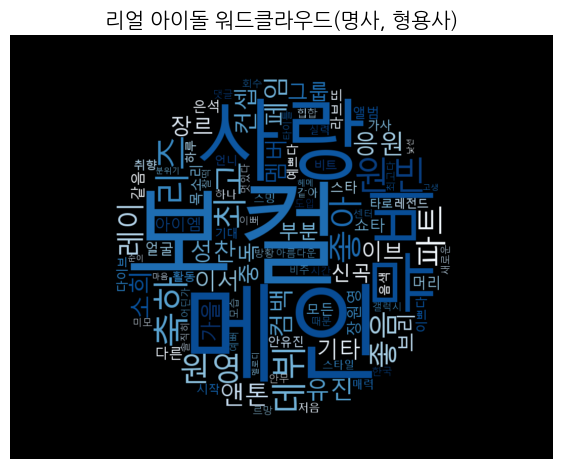

In [446]:
counter = Counter(word_list)

image = Image.open("C:\potenup3\pj01-data-analysis\images\circle.png")
mask_img = np.array(image)

wc = WordCloud(
    font_path = "C:/Windows/Fonts/malgun.ttf",      # 중요!
    background_color="black",
    mask=mask_img,
    width=800,
    height=400,
    colormap="Blues"
)

wc.generate_from_frequencies(dict(counter.most_common(100)))

plt.figure(figsize=(7,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('리얼 아이돌 워드클라우드(명사, 형용사)', fontsize=15)
plt.show()

In [447]:
sampled_virtual_df = sampled_df[~sampled_df['is_real']]

In [448]:
col = "keywords"
word_list = []

sampled_virtual_df[col] = sampled_virtual_df[col].map(parse_list_str)

sampled_virtual_df[col].head()

0               [역시, 노래, 중독, 있어야해]
1                        [진짜, 이뿌당]
2                    [노래, 좋아요, 엉엉]
3                             [오늘]
4    [토요일, 멜론, 차트, 없어요, 먼저, 죄송합니다]
Name: keywords, dtype: object

In [449]:
stop_set = set(stopwords)

word_list = [w for w in chain.from_iterable(sampled_virtual_df[col]) if w not in stop_set]

In [450]:
len(word_list)

30791

<>:3: DeprecationWarning: invalid escape sequence '\p'
<>:3: DeprecationWarning: invalid escape sequence '\p'
C:\Users\user\AppData\Local\Temp\ipykernel_26564\2824652288.py:3: DeprecationWarning: invalid escape sequence '\p'
  image = Image.open("C:\potenup3\pj01-data-analysis\images\circle.png")


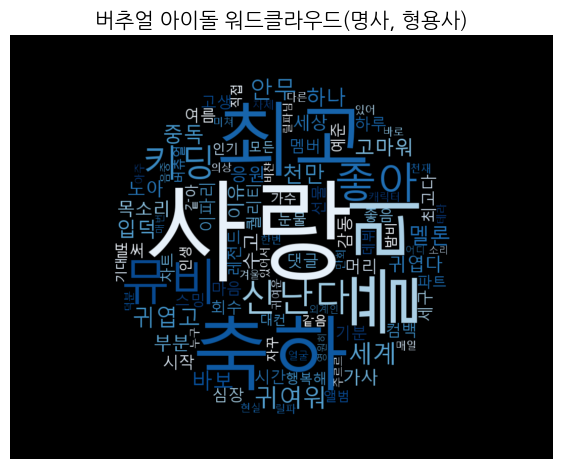

In [451]:
counter = Counter(word_list)

image = Image.open("C:\potenup3\pj01-data-analysis\images\circle.png")
mask_img = np.array(image)

wc = WordCloud(
    font_path = "C:/Windows/Fonts/malgun.ttf",      # 중요!
    background_color="black",
    mask=mask_img,
    width=800,
    height=400,
    colormap="Blues"
)

wc.generate_from_frequencies(dict(counter.most_common(100)))

plt.figure(figsize=(7,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('버추얼 아이돌 워드클라우드(명사, 형용사)', fontsize=15)
plt.show()

# 3. TF-IDF 벡터라이져

## 1) 리얼 TF-IDF

In [638]:
# 리스트를 공백을 기준으로한 문서들로 나눈 문자열로 하나의 리스트 만들기.
col = 'keywords'
sampled_real_df["tf-idf_text"] = sampled_real_df[col].apply(
    lambda xs: " ".join(
        w for w in xs
        if isinstance(w, str) and w not in stopwords
    )
)

sampled_real_df["tf-idf_text"].head()

4000    중국사람 가나 걸그룹 중국 애가 있어야
4001                    전설 하나
4002                    나하 좋와
4003                    막냉 많아
4004                       앨범
Name: tf-idf_text, dtype: str

In [639]:
doc_list = []

for doc in sampled_real_df["tf-idf_text"]:
    doc_list.append(doc)

doc_list[:5]

['중국사람 가나 걸그룹 중국 애가 있어야', '전설 하나', '나하 좋와', '막냉 많아', '앨범']

In [640]:
len(doc_list)

8000

In [641]:
# 1) TF-IDF (docs x terms)
vec = TfidfVectorizer()  # 한국어면 tokenizer를 형태소로 바꾸는 게 보통 더 좋음
X = vec.fit_transform(doc_list)
terms = vec.get_feature_names_out()


In [642]:
mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
mean_tfidf

array([5.23872109e-05, 5.60650691e-05, 4.73140072e-05, ...,
       7.59221129e-05, 3.55589320e-03, 9.03368860e-05], shape=(6645,))

In [643]:
tfidf_rank = sorted(
    zip(terms, mean_tfidf),
    key=lambda x: x[1],
    reverse=True
)

tfidf_rank[:50]

[('사랑', np.float64(0.04059137241698653)),
 ('최고', np.float64(0.017511497147202407)),
 ('좋아', np.float64(0.017385004255129677)),
 ('축하', np.float64(0.01564860550778858)),
 ('원빈', np.float64(0.0152645050931071)),
 ('데뷔', np.float64(0.01370852194332254)),
 ('뮤비', np.float64(0.013358355100566521)),
 ('리즈', np.float64(0.012369373105520476)),
 ('좋음', np.float64(0.01005935935238543)),
 ('페임', np.float64(0.00881329886042477)),
 ('파트', np.float64(0.008722210040819965)),
 ('레이', np.float64(0.008374069873399243)),
 ('원영', np.float64(0.008328725673639781)),
 ('이브', np.float64(0.008106529610304291)),
 ('앤톤', np.float64(0.0077479662178580955)),
 ('응원', np.float64(0.007747203069810607)),
 ('소희', np.float64(0.007404875555648804)),
 ('라브뜨', np.float64(0.007120516776904815)),
 ('컴백', np.float64(0.006762827091149838)),
 ('성찬', np.float64(0.006732804921181407)),
 ('신곡', np.float64(0.006628260800859023)),
 ('유진', np.float64(0.0065171280125565865)),
 ('브리', np.float64(0.006428102155728643)),
 ('중독', np.floa

In [644]:
X.toarray().shape[1]

6645

## 2) 버추얼 TF-IDF

In [738]:
# 리스트를 공백을 기준으로한 문서들로 나눈 문자열로 하나의 리스트 만들기.
col = 'keywords'
sampled_virtual_df["tf-idf_text"] = sampled_virtual_df[col].apply(
    lambda xs: " ".join(
        w for w in xs
        if isinstance(w, str) and w not in stopwords
    )
)

sampled_virtual_df["tf-idf_text"].head()

0                   중독 있어야해
1                       이뿌당
2                        엉엉
3                          
4    토요일 멜론 차트 없어요 먼저 죄송합니다
Name: tf-idf_text, dtype: str

In [739]:
doc_list = []

for doc in sampled_virtual_df["tf-idf_text"]:
    doc_list.append(doc)

print(len(doc_list))
doc_list[:5]

8000


['중독 있어야해', '이뿌당', '엉엉', '', '토요일 멜론 차트 없어요 먼저 죄송합니다']

In [740]:
vec = TfidfVectorizer()
X = vec.fit_transform(doc_list)
terms = vec.get_feature_names_out()

In [741]:
mean_tfidf = np.asarray(X.mean(axis=0)).ravel()

tfidf_rank = sorted(
    zip(terms, mean_tfidf),
    key=lambda x: x[1],
    reverse=True
)

tfidf_rank[:50]

[('사랑', np.float64(0.037328655386448334)),
 ('축하', np.float64(0.02714870063966751)),
 ('좋아', np.float64(0.015508840723293841)),
 ('귀여워', np.float64(0.012535619527840415)),
 ('플리', np.float64(0.012424312786462815)),
 ('키딩', np.float64(0.010927108538366617)),
 ('뮤비', np.float64(0.010784511013242638)),
 ('천만', np.float64(0.009940665764569102)),
 ('최고', np.float64(0.007946827260558263)),
 ('바보', np.float64(0.007334791610961793)),
 ('멜론', np.float64(0.007002131097564172)),
 ('세계', np.float64(0.007001482127488872)),
 ('중독', np.float64(0.00681458664434037)),
 ('최고다', np.float64(0.006648602271376545)),
 ('수고', np.float64(0.006454000188261446)),
 ('귀엽다', np.float64(0.00600853540854587)),
 ('안무', np.float64(0.005675685498321281)),
 ('고마워', np.float64(0.005454874806804383)),
 ('입덕', np.float64(0.005146718597413833)),
 ('노아', np.float64(0.004764150742650788)),
 ('레전드', np.float64(0.004719121411061636)),
 ('벌써', np.float64(0.004551193221752109)),
 ('귀엽고', np.float64(0.0044896373106679864)),
 ('이유',

In [742]:
X.toarray().shape[1]

7054

### TF-IDF 랭킹 엑셀 만들기

In [ ]:
## TF-IDF 랭킹 엑셀 만들기
normalized_score = mean_tfidf / mean_tfidf.max()

# dataframe
df_tfidf = pd.DataFrame({
    "keyword": terms,
    "mean_tfidf": mean_tfidf,
    "normalized_score": normalized_score
})

# 정렬 + rank
df_tfidf = (
    df_tfidf
    .sort_values("normalized_score", ascending=False)
    .reset_index(drop=True)
)

df_tfidf["rank"] = df_tfidf.index + 1

df_tfidf = df_tfidf[["rank", "keyword", "mean_tfidf", "normalized_score"]]

df_tfidf.head(30).to_excel(
    "tfidf_keyword_ranking_top20.xlsx",
    index=False
)

# 4. CONCOR 분석 시각화 파일 만들기

## 1) .dl 파일 만들기 - 노드 개수 줄이기

In [743]:
grp_name = 'Virtual'

# n개의 단어만 시각화 하기
n = 80
k = 5
t = 0.25
symmetric_mode = "min"

vec = TfidfVectorizer(
    max_features=n,
    min_df=5,            # 너무 희귀한 단어 제거
    max_df=0.8           # 너무 흔한 단어 제거
)
X = vec.fit_transform(doc_list)
terms = vec.get_feature_names_out()


mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
top_idx = np.argsort(mean_tfidf)[::-1][:n]   # 예: 상위 n개 단어만

X_top = X[:, top_idx]
terms_top = terms[top_idx]

M_cos = cosine_similarity(X_top.T)  # (3000 x 3000)면 manageable
np.fill_diagonal(M_cos, 0.0)

M_topk = keep_topk_per_row(M_cos, k=k, symmetric=symmetric_mode)
M_topk[M_topk < t] = 0.0

dfM = pd.DataFrame(M_cos, index=terms_top, columns=terms_top)

save_ucinet_dl_fullmatrix(dfM, f"word_similarity_{grp_name}.dl")
print(f"Saved: word_similarity_{grp_name}.dl")

Saved: word_similarity_Virtual.dl


In [744]:
## 단어 빈도수로 노드 크기 바꾸는 UCINET6 .att 파일 생성
# 1) CountVectorizer로 단어 빈도
cv = CountVectorizer(vocabulary=terms_top)
C = cv.fit_transform(doc_list)

term_freq = np.asarray(C.sum(axis=0)).ravel()

# 2) UCINET용 DataFrame (ID 필수)
df_att = pd.DataFrame({
    "ID": terms_top,        # 네트워크 노드 라벨과 반드시 동일
    "freq": term_freq
})

# 3) 탭 구분 + CP949 인코딩으로 저장
df_att.to_csv(
    f"word_freq_{grp_name}.att",
    sep="\t",               # 🔥 중요
    index=False,
    encoding="CP949"
)


# 5. N-gram 분석

## 1) Unigram

nodes: 80 edges: 103


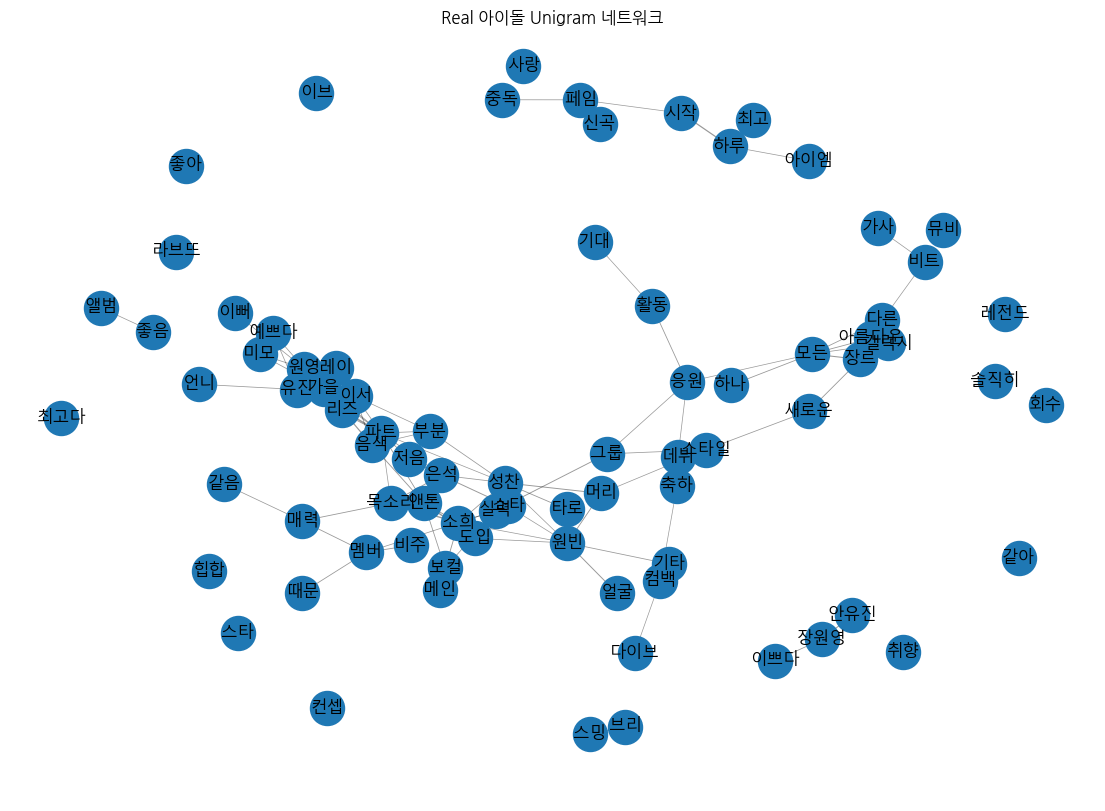

In [670]:
k = 12
symmetric_mode = "min"

M_plot = keep_topk_per_row(M_cos, k=k, symmetric=symmetric_mode)

vals = M_plot[M_plot > 0]
t = np.percentile(vals, 70)   # 상위 30%만 유지
M_plot[M_plot < t] = 0.0

G = nx.Graph()
G.add_nodes_from(terms_top)

# (i<j) 상삼각만 돌면서 엣지 추가
n = len(terms_top)
for i in range(n):
    for j in range(i+1, n):
        w = float(M_plot[i, j])
        if w > 0:
            G.add_edge(terms_top[i], terms_top[j], weight=w)

print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

pos = nx.spring_layout(G, seed=42, k=0.09)  # k는 퍼짐 정도 (작으면 더 뭉침)

# 엣지 두께를 weight로
weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
widths = 0.5 + 3.0 * (weights - weights.min()) / (np.ptp(weights) + 1e-9)

plt.figure(figsize=(14, 10))
plt.title(f"{grp_name} 아이돌 Unigram 네트워크")
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.4)
nx.draw_networkx_nodes(G, pos, node_size=600)
nx.draw_networkx_labels(G, pos, font_size=12, font_family="Malgun Gothic")
plt.axis("off")
plt.show()

## 2) N-gram

nodes: 80 edges: 131


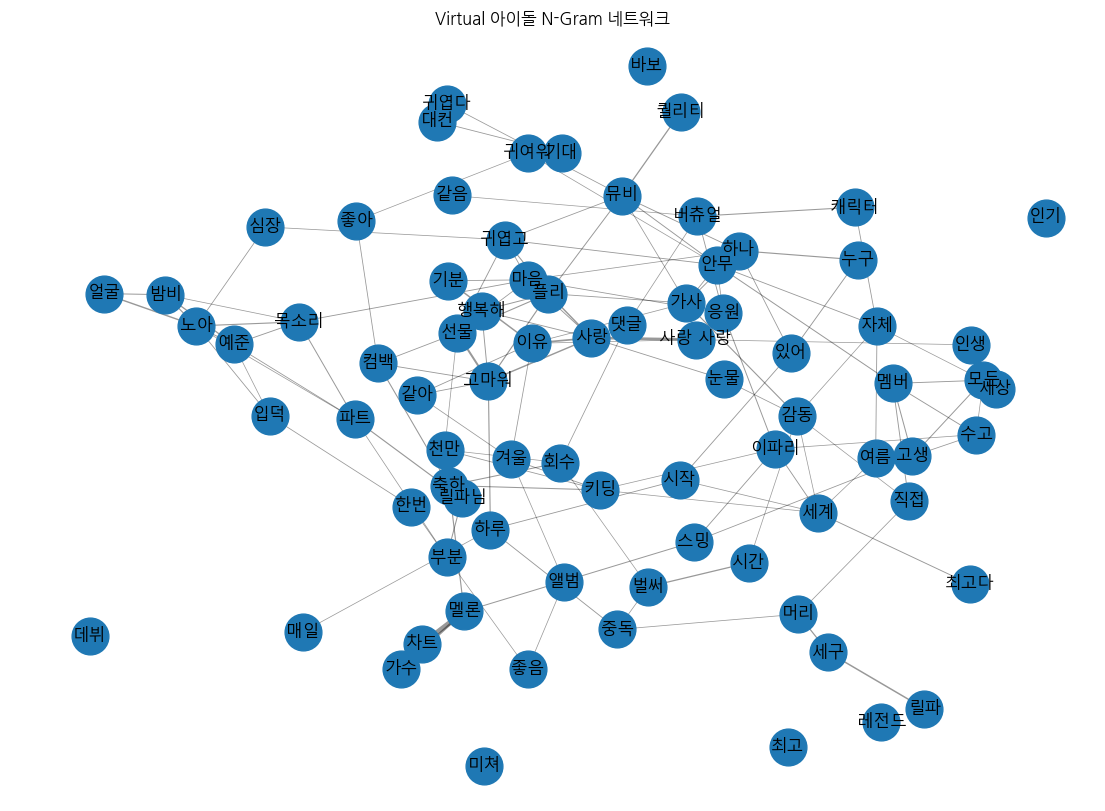

In [750]:
k = 7
percentage = 70
symmetric_mode = "min"

vec = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=n,
    min_df=5,            # 너무 희귀한 단어 제거
    max_df=0.8           # 너무 흔한 단어 제거
)
X = vec.fit_transform(doc_list)
terms = vec.get_feature_names_out()

mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
top_idx = np.argsort(mean_tfidf)[::-1][:n]   # 예: 상위 n개 단어만

X_top = X[:, top_idx]
terms_top = terms[top_idx]

M_cos = cosine_similarity(X_top.T)  # (3000 x 3000)면 manageable

M_plot = keep_topk_per_row(M_cos, k=k, symmetric=symmetric_mode)

vals = M_plot[M_plot > 0]
t = np.percentile(vals, 100-percentage)   # 상위 30%만 유지
M_plot[M_plot < t] = 0.0

G = nx.Graph()
G.add_nodes_from(terms_top)

# (i<j) 상삼각만 돌면서 엣지 추가
n = len(terms_top)
for i in range(n):
    for j in range(i+1, n):
        w = float(M_plot[i, j])
        if w > 0:
            G.add_edge(terms_top[i], terms_top[j], weight=w)

print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

pos = nx.spring_layout(G, seed=42, k=0.12)  # k는 퍼짐 정도 (작으면 더 뭉침)

# 엣지 두께를 weight로
weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
widths = 0.5 + 3.0 * (weights - weights.min()) / (np.ptp(weights) + 1e-9)

plt.figure(figsize=(14, 10))
plt.title(f"{grp_name} 아이돌 N-Gram 네트워크")
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.4)
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_labels(G, pos, font_size=12, font_family="Malgun Gothic")
plt.axis("off")
plt.show()

# 6. LDA 분석 ( 담론 주제별 분화 시각화 )

In [57]:
df = pd.read_csv(
    "../cocacoca0810/data/01_raw/processed/youtube_comments_clean.csv",
    index_col=0
)

df.head()

,video_id,comment_id,like_count,published_at,datetime,cleaned_comment
0,k5O1F_IS0mU,Ugykjh0_hVuTgqN8doR4AaABAg,0,2026-01-31T15:59:29Z,2026-01-31 15:59:29,그냥 얘들아 내가 진짜 애정한다 나 이렇게 애정해본 아이돌이 너네가 처음이고 콘서트...
1,k5O1F_IS0mU,Ugx1c4OKEnkVwGWBlFB4AaABAg,2,2026-01-23T04:29:25Z,2026-01-23 04:29:25,눈물이 난다
2,k5O1F_IS0mU,UgwaAbmKOm2vwOgFEFp4AaABAg,2,2026-01-20T01:52:56Z,2026-01-20 01:52:56,이 노래도 겁나 좋네
3,k5O1F_IS0mU,UgzquReVBuSocVLtI7t4AaABAg,3,2026-01-19T11:10:22Z,2026-01-19 11:10:22,패러블 이제 뉴세돌로 리와인드 다시 찍어 올려라 이세돌 더 이쁜 버전으로 보고 싶다
4,k5O1F_IS0mU,UgwM02x2Puib48rQTuF4AaABAg,2,2026-01-16T02:53:32Z,2026-01-16 02:53:32,언제 들어도 행복하고 좋은 노래


In [58]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 218104 entries, 0 to 218103
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   video_id         218104 non-null  str  
 1   comment_id       218104 non-null  str  
 2   like_count       218104 non-null  int64
 3   published_at     218104 non-null  str  
 4   datetime         218104 non-null  str  
 5   cleaned_comment  72796 non-null   str  
dtypes: int64(1), str(5)
memory usage: 10.0 MB


In [60]:
df = df.dropna()
df.info()

<class 'pandas.DataFrame'>
Index: 72796 entries, 0 to 218100
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   video_id         72796 non-null  str  
 1   comment_id       72796 non-null  str  
 2   like_count       72796 non-null  int64
 3   published_at     72796 non-null  str  
 4   datetime         72796 non-null  str  
 5   cleaned_comment  72796 non-null  str  
dtypes: int64(1), str(5)
memory usage: 3.9 MB


In [61]:
# 컬럼의 데이터가 전부 str 인지 확인
df["cleaned_comment"].apply(type).value_counts()

cleaned_comment
<class 'str'>    72796
Name: count, dtype: int64

In [ ]:
video_to_group = {
    "8L001YT4k6k": "PLAVE",
    "EYG4ROejmyI": "PLAVE",
    "T_gJpnjJsnk": "PLAVE",

    "bltjk6NfDQM": "IVE",
    "B1ShLiq3EVc": "IVE",
    "6ZUIwj3FgUY": "IVE",
    
    "iUw3LPM7OBU": "RIIZE",
    "3_b5oKGndn0": "RIIZE",
    "TVqEwvbZP30": "RIIZE",
    
    "k5O1F_IS0mU": "ISEGYE IDOL",
    "rDFUl2mHIW4": "ISEGYE IDOL",
    "fff8P0kYexQ": "ISEGYE IDOL"
}

df["group"] = df["video_id"].map(video_to_group)
df["group"].value_counts()

In [ ]:
# V와 R 나누기 위한 컬럼 추가
is_real_mask = df['group'].str.contains(r'RIIZE|IVE', case=False)
df["idol_type"] = np.where(is_real_mask, "리얼", "버추얼")
df.head()

In [73]:
df["idol_type"].value_counts()

idol_type
버추얼    40675
리얼     32121
Name: count, dtype: int64

In [77]:
real_df = df[is_real_mask]
real_df.shape

(32121, 8)

In [78]:
virtual_df = df[~is_real_mask]
virtual_df.shape

(40675, 8)

In [ ]:
## 느린코드
kiwi = Kiwi()

# STEP1. 전처리한 문장을 담을 빈리스트를 준비한다. sent_list
sent_list = []

# STEP2. df["text"]에서 문장을 하나씩 뺸다.
for sent in virtual_df["cleaned_comment"]:

    # STEP4. clean_sent를 토크나이징한다. (Kiwi형태소 분석기 사용) result
    result = kiwi.tokenize(sent)
    
    sub_list = []
    for x in result:
        word = x.form
        pos = x.tag
        
        if pos[0] in ["J", "E", "X"]:
            continue
        
        # ✔ 동사 / 형용사는 lemma 사용
        if pos.startswith(("V", "A")):
            word = x.lemma

        if len(word) > 1:
            sub_list.append(word)

    # STEP5. result를 " "를 구분자로 하나의 문자열로 합친다. result_str
    result_str = " ".join(sub_list)
    #print(f"orig: {sent}")
    #print(f"prep: {result_str}")
    # STEP6. result_str을 sent_list에 넣는다.
    sent_list.append(result_str)
    #print("="*50)

In [79]:
# 5~7배 빠른코드
kiwi = Kiwi()

sent_list = []

# STEP1. NaN 제거 + 리스트 변환
texts = real_df["cleaned_comment"].dropna().tolist()

# STEP2. 한번에 토큰화
tokenized = kiwi.tokenize(texts)

# STEP3. 결과 후처리
for tokens in tokenized:

    sub_list = []

    for x in tokens:

        pos = x.tag

        if pos[0] in ["J", "E", "X"]:
            continue

        word = x.lemma if pos.startswith(("V", "A")) else x.form

        if len(word) > 1:
            sub_list.append(word)

    sent_list.append(" ".join(sub_list))
    
print(len(sent_list))

32121


In [80]:
count_vectorizer = CountVectorizer(
    max_df=0.15,         # 전체 단어의 등장 비율이 p이상인 것만 사용
    min_df=3,           # 이 단어가 적어도 n개 이상 있는 것만 사용
    max_features=3000,  # 최대 몇 개까지 나타낼 것인가
    ngram_range=(1,2)   # 단어의 조합 설정(ex. 1개만 사용)
)
feat_vec = count_vectorizer.fit_transform(sent_list)
# 문장 -> 스페이스 기준으로 쪼갠다. -> 단어들이 나열
# 각 문장마다 단어가 몇번 들어가 있는지 카운트를 세고
feat_vec.shape

(32121, 3000)

In [81]:
# 1. Sparse Matrix를 일반 배열(Dense)로 변환: .toarray()
# 2. 열 이름(단어 목록) 가져오기: get_feature_names_out()
df_vec = pd.DataFrame(
    feat_vec.toarray(),
    columns=count_vectorizer.get_feature_names_out()
)

# 결과 확인
df_vec.head()

,가능,가다,가다 가다,가다 너무,가다 노래,가다 듣다,가다 보다,가다 싶다,가다 이다,가다 있다,...,흥하다,희망,히트,히트 치다,히트곡,힐링,힘내다,힘들다,힘들다 이다,힙합
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
lda = LatentDirichletAllocation(n_components=5) # 몇 개의 topic으로 할까요?
lda.fit(feat_vec)

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",5
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",10
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [91]:
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda, feat_vec, count_vectorizer)
pyLDAvis.display(vis)

In [92]:
# 5~7배 빠른코드
kiwi = Kiwi()

sent_list = []

# STEP1. NaN 제거 + 리스트 변환
texts = virtual_df["cleaned_comment"].dropna().tolist()

# STEP2. 한번에 토큰화
tokenized = kiwi.tokenize(texts)

# STEP3. 결과 후처리
for tokens in tokenized:

    sub_list = []

    for x in tokens:

        pos = x.tag

        if pos[0] in ["J", "E", "X"]:
            continue

        word = x.lemma if pos.startswith(("V", "A")) else x.form

        if len(word) > 1:
            sub_list.append(word)

    sent_list.append(" ".join(sub_list))
    
print(len(sent_list))

40675


In [93]:
count_vectorizer = CountVectorizer(
    max_df=0.15,         # 전체 단어의 등장 비율이 p이상인 것만 사용
    min_df=3,           # 이 단어가 적어도 n개 이상 있는 것만 사용
    max_features=3000,  # 최대 몇 개까지 나타낼 것인가
    ngram_range=(1,2)   # 단어의 조합 설정(ex. 1개만 사용)
)
feat_vec = count_vectorizer.fit_transform(sent_list)
# 문장 -> 스페이스 기준으로 쪼갠다. -> 단어들이 나열
# 각 문장마다 단어가 몇번 들어가 있는지 카운트를 세고
feat_vec.shape

(40675, 3000)

In [94]:
# 1. Sparse Matrix를 일반 배열(Dense)로 변환: .toarray()
# 2. 열 이름(단어 목록) 가져오기: get_feature_names_out()
df_vec = pd.DataFrame(
    feat_vec.toarray(),
    columns=count_vectorizer.get_feature_names_out()
)

# 결과 확인
df_vec.head()

,가게,가까이,가까이 다가오다,가까이 오다,가깝다,가깝다 지다,가끔,가능,가다,가다 가다,...,흑흑,흘리다,흥얼거리다,흥하다,희다,히히,힐링,힘내다,힘들다,힘들다 이다
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
lda = LatentDirichletAllocation(n_components=5) # 몇 개의 topic으로 할까요?
lda.fit(feat_vec)

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",5
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",10
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [96]:
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda, feat_vec, count_vectorizer)
pyLDAvis.display(vis)